In [12]:
#Imports
import pandas as pd
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
import numpy as np
from keras.src.layers import Dropout
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve, auc
import seaborn as sns

In [13]:
#Data importing
dataFrame = pd.read_csv('./dataset.csv')

# variable I will try to predict: popularity
# the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/

dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

                     duration_ms  explicit  danceability    energy       key  \
duration_ms             1.000000 -0.065263     -0.073426  0.058523  0.008114   
explicit               -0.065263  1.000000      0.122507  0.096955  0.004484   
danceability           -0.073426  0.122507      1.000000  0.134325  0.036469   
energy                  0.058523  0.096955      0.134325  1.000000  0.048006   
key                     0.008114  0.004484      0.036469  0.048006  1.000000   
loudness               -0.003470  0.108588      0.259077  0.761690  0.038590   
mode                   -0.035556 -0.037212     -0.069219 -0.078362 -0.135916   
speechiness            -0.062600  0.307952      0.108626  0.142509  0.020418   
acousticness           -0.103788 -0.094403     -0.171533 -0.733906 -0.040937   
instrumentalness        0.124371 -0.103404     -0.185606 -0.181879 -0.006823   
liveness                0.010321  0.032549     -0.131617  0.184796 -0.001600   
valence                -0.154479 -0.0033

<Axes: >

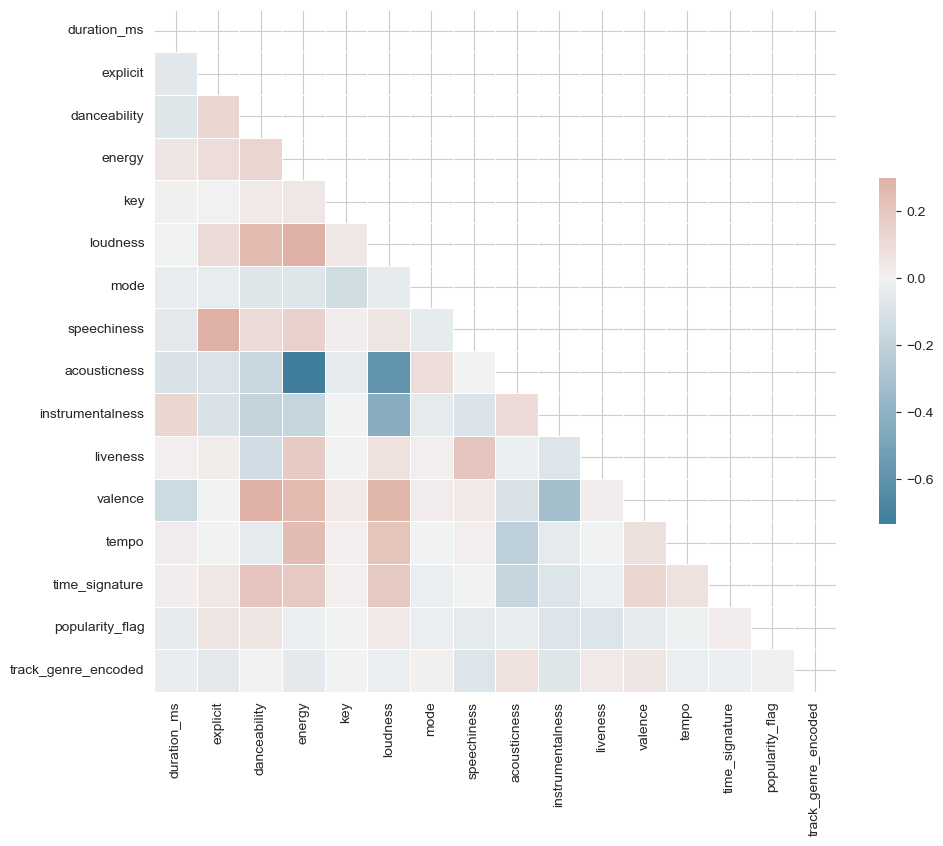

In [18]:
# Calculate correlation matrix
corr_matrix = dataFrame.corr()

# Show correlation matrix
print(corr_matrix)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True,)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Label to integer mapping: {'acoustic': 0, 'afrobeat': 1, 'alt-rock': 2, 'alternative': 3, 'ambient': 4, 'anime': 5, 'black-metal': 6, 'bluegrass': 7, 'blues': 8, 'brazil': 9, 'breakbeat': 10, 'british': 11, 'cantopop': 12, 'chicago-house': 13, 'children': 14, 'chill': 15, 'classical': 16, 'club': 17, 'comedy': 18, 'country': 19, 'dance': 20, 'dancehall': 21, 'death-metal': 22, 'deep-house': 23, 'detroit-techno': 24, 'disco': 25, 'disney': 26, 'drum-and-bass': 27, 'dub': 28, 'dubstep': 29, 'edm': 30, 'electro': 31, 'electronic': 32, 'emo': 33, 'folk': 34, 'forro': 35, 'french': 36, 'funk': 37, 'garage': 38, 'german': 39, 'gospel': 40, 'goth': 41, 'grindcore': 42, 'groove': 43, 'grunge': 44, 'guitar': 45, 'happy': 46, 'hard-rock': 47, 'hardcore': 48, 'hardstyle': 49, 'heavy-metal': 50, 'hip-hop': 51, 'honky-tonk': 52, 'house': 53, 'idm': 54, 'indian': 55, 'indie': 56, 'indie-pop': 57, 'industrial': 58, 'iranian': 59, 'j-dance': 60, 'j-idol': 61, 'j-pop': 62, 'j-rock': 63, 'jazz': 64, 'k-pop': 65, 'kids': 66, 'latin': 67, 'latino': 68, 'malay': 69, 'mandopop': 70, 'metal': 71, 'metalcore': 72, 'minimal-techno': 73, 'mpb': 74, 'new-age': 75, 'opera': 76, 'pagode': 77, 'party': 78, 'piano': 79, 'pop': 80, 'pop-film': 81, 'power-pop': 82, 'progressive-house': 83, 'psych-rock': 84, 'punk': 85, 'punk-rock': 86, 'r-n-b': 87, 'reggae': 88, 'reggaeton': 89, 'rock': 90, 'rock-n-roll': 91, 'rockabilly': 92, 'romance': 93, 'sad': 94, 'salsa': 95, 'samba': 96, 'sertanejo': 97, 'show-tunes': 98, 'singer-songwriter': 99, 'ska': 100, 'sleep': 101, 'songwriter': 102, 'soul': 103, 'spanish': 104, 'study': 105, 'swedish': 106, 'synth-pop': 107, 'tango': 108, 'techno': 109, 'trance': 110, 'trip-hop': 111, 'turkish': 112, 'world-music': 113}

In [3]:
inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity_flag']

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)

In [5]:
# Assuming y_train is your training labels
positive_class_proportion = np.mean(ytrain)

print(f"The AUPRC baseline is: {positive_class_proportion}")

The AUPRC baseline is: popularity_flag    0.24455
dtype: float64


/Users/benfunk/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [6]:
model = neighbors.KNeighborsRegressor(2)
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)
ypred = (ypred > 0.5).astype(int)  # Apply a threshold 

y_train_scores = model.predict(xtrain)
y_test_scores = model.predict(xtest)

#Apply same threshold to train predictions
y_train_pred = (y_train_scores > 0.5).astype(int)
y_test_pred = (y_test_scores > 0.5).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

AUPRC on Training set: 0.8022429232302499
AUPRC on Testing set: 0.49061103748163354


In [7]:
model = neighbors.KNeighborsClassifier(n_neighbors=2)
model.fit(xtrain, ytrain.values.ravel())
y_train_scores = model.predict_proba(xtrain)[:, 1]
y_test_scores = model.predict_proba(xtest)[:, 1]

#Apply same threshold to train predictions
y_train_pred = (y_train_scores > 0.5).astype(int)
y_test_pred = (y_test_scores > 0.5).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

AUPRC on Training set: 0.8022429232302499
AUPRC on Testing set: 0.49061103748163354


In [8]:
# Data importing
dataFrame = pd.read_csv('./dataset.csv')
dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

# Split into features and target
X = dataFrame.drop(columns=['popularity_flag'])
y = dataFrame['popularity_flag']

# Convert to tensor
X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y.values, dtype=tf.float32)

# Calculate the index at which to split the dataset
train_size = int(0.8 * len(X))

# Manually slice the tensors for train/test sets
x_train_tensor = X_tensor[:train_size]
y_train_tensor = y_tensor[:train_size]
x_test_tensor = X_tensor[train_size:]
y_test_tensor = y_tensor[train_size:]


In [9]:
@keras.saving.register_keras_serializable()
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@keras.saving.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_true,y_pred))

@keras.saving.register_keras_serializable()
def r_squared(y_true, y_pred,):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

@keras.saving.register_keras_serializable()
def r_squared_loss(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return 1 - r2  # or you can return -r2 to minimize the negative value

def custom_loss(y_true, y_pred):
    # Assign costs
    cost_fp = 2.0  # cost of a false positive
    cost_fn = 5.0  # cost of a false negative

    # Calculate binary cross-entropy
    bce = tf.keras.losses.BinaryCrossentropy()
    base_loss = bce(y_true, y_pred)

    # Calculate false positives and false negatives
    y_pred_binary = tf.round(y_pred)
    fp = tf.math.reduce_sum(tf.math.multiply(tf.math.subtract(y_pred_binary, y_true), cost_fp))
    fn = tf.math.reduce_sum(tf.math.multiply(tf.math.subtract(y_true, y_pred_binary), cost_fn))

    # Add to base loss
    return base_loss + fp + fn

def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

In [10]:
input_shape = (x_train_tensor.shape[1],)


# Build model function
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Class weights for cost-sensitive training
class_weights = {0: 1., 1: 3.9}  # You can fine-tune this based on your specific case
early_stopping = EarlyStopping(monitor='accuracy', patience=50, restore_best_weights=True)

with tf.device('/GPU:0'):
    #regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    model.fit(x_train_tensor, y_train_tensor, epochs=20,validation_split=0.2, batch_size=200,class_weight=class_weights)

    ypred = model.predict(x_test_tensor)
    ypred = (ypred > 0.5).astype(int)  # Apply a threshold

    y_test_numpy = y_test_tensor.numpy()

# get predictions as probabilities
y_train_scores = model.predict(x_train_tensor).flatten()
y_test_scores = model.predict(x_test_tensor).flatten()

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train_tensor, y_train_scores)
precision_test, recall_test, _ = precision_recall_curve(y_test_tensor, y_test_scores)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

Epoch 1/20
365/365 [==============================] - 0s 608us/step - loss: 421.8993 - accuracy: 0.3661 - val_loss: 0.7561 - val_accuracy: 0.2698
Epoch 2/20
365/365 [==============================] - 0s 425us/step - loss: 1.1785 - accuracy: 0.2482 - val_loss: 0.7682 - val_accuracy: 0.2698
Epoch 3/20
365/365 [==============================] - 0s 414us/step - loss: 1.1786 - accuracy: 0.2482 - val_loss: 0.7679 - val_accuracy: 0.2698
Epoch 4/20
365/365 [==============================] - 0s 417us/step - loss: 1.1786 - accuracy: 0.2482 - val_loss: 0.7663 - val_accuracy: 0.2698
Epoch 5/20
365/365 [==============================] - 0s 418us/step - loss: 1.1786 - accuracy: 0.2482 - val_loss: 0.7575 - val_accuracy: 0.2698
Epoch 6/20
365/365 [==============================] - 0s 414us/step - loss: 1.1786 - accuracy: 0.2482 - val_loss: 0.7569 - val_accuracy: 0.2698
Epoch 7/20
365/365 [==============================] - 0s 419us/step - loss: 1.1786 - accuracy: 0.2482 - val_loss: 0.7694 - val_accurac

In [11]:
#Data importing
dataFrame = pd.read_csv('./dataset.csv')

# variable I will try to predict: popularity
# the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/

dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > 50, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity_flag']

X_train, X_test, y_train, y_test = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Print the confusion matrix using Matplotlib
y_train_scores_dt = dt.predict_proba(X_train)[:, 1]
y_test_scores_dt = dt.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

AUPRC on Training set: 0.9995438542449004
AUPRC on Testing set: 0.5892483905553867


In [28]:

#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train.values.ravel())
y_train_predrf = rf.predict(X_train)
y_test_predrf = rf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_true=y_test, y_pred=y_test_predrf)


y_train_scores_dt = rf.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")


AUPRC on Training set: 0.9986238265622894
AUPRC on Testing set: 0.7408075325573321


In [29]:
def custom_auc(y_true, y_pred):
    # check if y_pred is 1-dimensional
    if len(y_pred.shape) == 1:
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
    else:
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    return auc(recall, precision)

# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [20,  80, 100],
    'max_features': ['sqrt'],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf_0 = RandomForestClassifier(n_jobs=-1, random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_0, param_grid=param_grid, scoring=make_scorer(custom_auc, needs_proba=True))
grid_search.fit(X_train, y_train.values.ravel())
print ('Best Parameters: ', grid_search.best_params_, ' \n')

#Create a Gaussian Classifier
rf2=RandomForestClassifier(n_estimators=1000, max_depth = 100, max_features = 'sqrt', min_samples_leaf =1,min_samples_split =2, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf2.fit(X_train, y_train.values.ravel())

y_train_scores_dt = rf2.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf2.predict_proba(X_test)[:, 1]

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

KeyboardInterrupt: 